# Cellular automata

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 5

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Zero-dimensional CA

In [3]:
n = 10
x = np.zeros(n)
print(x)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [4]:
x[1] = (x[0] + 1) % 2
x[1]

1.000

In [5]:
for i in range(2, 10):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[ 0.  1.  0.  1.  0.  1.  0.  1.  0.  1.]


## One-dimensional CA

In [6]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.int8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [7]:
def plot_ca(array):
    cmap = plt.get_cmap('Blues')
    plt.imshow(array, interpolation='none', cmap=cmap)

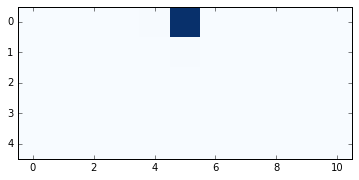

In [8]:
plot_ca(array)

In [9]:
def step(array, i):
    rows, cols = array.shape
    for j in range(1, cols):
        array[i, j] = sum(array[i-1, j-1:j+2]) % 2

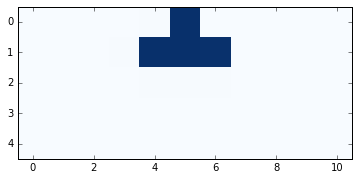

In [10]:
step(array, 1)
plot_ca(array)

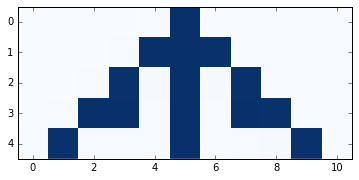

In [11]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

## Convolution

In [12]:
window = np.zeros(cols, dtype=np.int8)
window[:3] = 1
print(window)
print(array[4])
print(window * array[4])

[1 1 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 0 0 0 1 0]
[0 1 0 0 0 0 0 0 0 0 0]


In [13]:
sum(window * array[4]) % 2

1

In [14]:
window = np.roll(window, 1)
print(window)

[0 1 1 1 0 0 0 0 0 0 0]


In [15]:
sum(window * array[4]) % 2

1

In [16]:
def step2(array, i):
    rows, cols = array.shape
    window = np.zeros(cols)
    window[:3] = 1
    for j in range(1, cols):
        array[i, j] = sum(window * array[i-1]) % 2
        window = np.roll(window, 1)

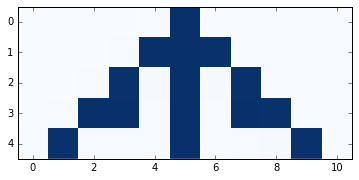

In [17]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

In [18]:
def step3(array, i):
    window = np.array([1, 1, 1])
    array[i] = np.convolve(array[i-1], window, mode='same') % 2

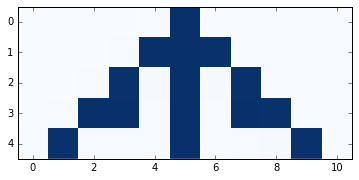

In [19]:
for i in range(1, rows):
    step3(array, i)

plot_ca(array)

In [20]:
def make_table(rule):
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

In [21]:
def print_table(table):
    """Prints the rule table in LaTeX format."""
    print('\\beforefig')
    print('\\centerline{')
    print('\\begin{tabular}{|c|c|c|c|c|c|c|c|c|}')
    print('\\hline')

    res = ['prev'] + ['{0:03b}'.format(i) for i in range(8)]
    print(' & '.join(res) + ' \\\\ \n\\hline')

    res = ['next'] + [str(x) for x in table]
    print(' &   '.join(res) + ' \\\\ \n\\hline')

    print('\\end{tabular}}')

In [22]:
table = make_table(150)
print(table)

[0 1 1 0 1 0 0 1]


In [23]:
window = [1,2,4]
convolved = np.convolve(array[0], window, mode='same')
print(convolved)

[0 0 0 0 1 2 4 0 0 0 0]


In [24]:
array[1] = table[convolved]
print(array[1])

[0 0 0 0 1 1 1 0 0 0 0]


In [25]:
def step4(array, i):
    window = np.array([1, 2, 4])
    convolved = np.convolve(array[i-1], window, mode='same')
    array[i] = table[convolved]

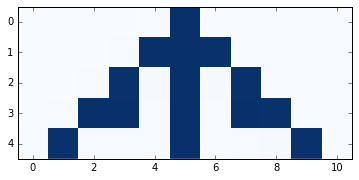

In [26]:
for i in range(1, rows):
    step4(array, i)

plot_ca(array)

In [27]:
import numpy as np

class CA(object):
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, ratio=2):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns


        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = int(ratio * n + 1)
        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.random(self.m).round()
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [1,2,4]
        convolved = np.convolve(a[i-1], window, mode='same')
        a[i] = self.table[convolved]
        self.next += 1

    def get_array(self, start=0, end=None):
        """Gets a slice of columns from the CA.

        Avoids copying if possible.

        start: index of first column
        end: index of the last column plus one
        """
        if start==0 and end==None:
            return self.array
        else:
            return self.array[:, start:end]

In [28]:
import numpy as np
import matplotlib.pyplot as plt


class PyplotDrawer:
    """Draw a CA object using matplotlib."""
        
    def draw(self, ca, start=0, end=None):
        """Draws the CA using pyplot.pcolor.
        
        start: index of the first column to be shown 
        end: index of the last column to be shown
        """
        a = ca.get_array(start, end)
        cmap = plt.get_cmap('Blues')
        plt.imshow(a, interpolation='none', cmap=cmap)

        # empty lists draw no ticks
        plt.xticks([])
        plt.yticks([])

    def show(self):
        """Displays the representation of the CA"""
        plt.show()

    def save(self, filename='ca.png'):
        """Saves the representation of the CA.
        
        filename: string
        """
        plt.savefig(filename)

In [ ]:
class EPSDrawer:
    """Draw a CA using encapsulated Postscript (EPS)."""

    def draw(self, ca, start=0, end=None):
        """Draws the CA using pyplot.pcolor.
        
        start: index of the first column to be shown 
        end: index of the last column to be shown
        """
        a = ca.get_array(start, end)
        self.n, self.m = a.shape
        
        self.cells = []
        for i in xrange(self.n):
            for j in xrange(self.m):
                if a[i, j]:
                    self.cells.append((i, j))
        
    def save(self, filename='ca.eps'):
        """Saves the representation of the CA.
        
        filename: string
        """
        with open(filename, 'w') as fp:
            self.print_header(fp)
            self.print_outline(fp)
            self.print_cells(fp)
            self.print_footer(fp)

    def print_header(self, fp, size=0.9, border=2):
        """Writes the EPS header and defines /c."""
        fp.write('%!PS-Adobe-3.0 EPSF-3.0\n')
        fp.write('%%%%BoundingBox: %d %d %d %d\n' % 
                 (border, border, self.m+border, self.n+border))

        fp.write('1 -1 scale\n')
        fp.write('0 %d translate\n' % -self.n)
        fp.write('/c {\n')
        fp.write('   newpath moveto\n')
        fp.write('   0 %g rlineto\n' % size)
        fp.write('   %g 0 rlineto\n' % size)
        fp.write('   0 -%g rlineto\n' % size)
        fp.write('   closepath fill\n')
        fp.write('} def\n')

    def print_outline(self, fp):
        """Writes the code that draws the outline."""
        fp.write('newpath 0.1 setlinewidth 0 0 moveto\n')
        fp.write('0 %d rlineto\n' % self.n)
        fp.write('%d 0 rlineto\n' % self.m)
        fp.write('0 -%d rlineto\n' % self.n)
        fp.write('closepath stroke\n')

    def print_cells(self, fp):
        """Writes the code that draws the cells."""
        for i, j in self.cells:
            fp.write('%d %d c\n' % (j, i))

    def print_footer(self, fp):
        """Writes the footer code."""
        fp.write('%%EOF\n')

In [29]:
rule = 50
n = 10
ca = CA(rule, n)
ca.start_single()
ca.loop(n-1)

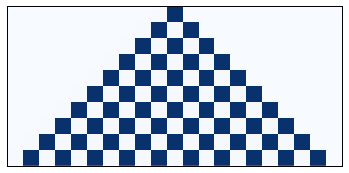

In [30]:
drawer = PyplotDrawer()
drawer.draw(ca)
drawer.show()
drawer.save('chap05-1.png')

In [31]:
drawer = EPSDrawer()
drawer.draw(ca)
drawer.save('chap05-1.eps')

In [49]:
print(ca.table)

[0 1 1 1 0 1 1 0]


In [33]:
rule = 150
n = 5
ca = CA(rule, n)
ca.start_single()
ca.loop(n-1)

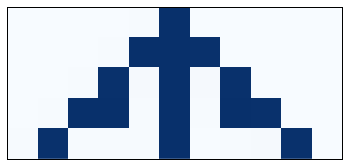

In [34]:
drawer = PyplotDrawer()
drawer.draw(ca)

In [35]:
drawer = EPSDrawer()
drawer.draw(ca)
drawer.save('chap05-2.eps')

In [36]:
rule = 18
n = 64
ca = CA(rule, n)
ca.start_single()
ca.loop(n-1)

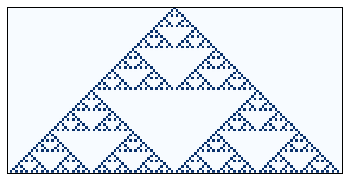

In [37]:
drawer = PyplotDrawer()
drawer.draw(ca)

In [38]:
drawer = EPSDrawer()
drawer.draw(ca)
drawer.save('chap05-3.eps')

In [39]:
rule = 30
n = 100
ca = CA(rule, n)
ca.start_single()
ca.loop(n-1)

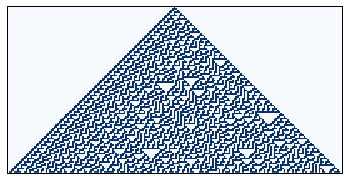

In [40]:
drawer = PyplotDrawer()
drawer.draw(ca)

In [41]:
drawer = EPSDrawer()
drawer.draw(ca)
drawer.save('chap05-4.eps')

In [42]:
rule = 110
n = 100
ca = CA(rule, n)
ca.start_single()
ca.loop(n-1)

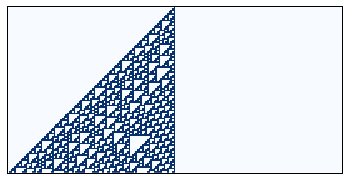

In [43]:
drawer = PyplotDrawer()
drawer.draw(ca)

In [44]:
drawer = EPSDrawer()
drawer.draw(ca)
drawer.save('chap05-5.eps')

In [45]:
rule = 110
n = 600
ca = CA(rule, n)
ca.start_random()
ca.loop(n-1)

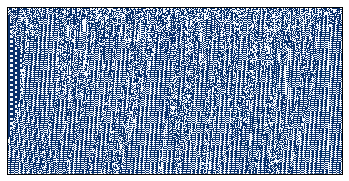

In [46]:
drawer = PyplotDrawer()
drawer.draw(ca)

In [47]:
drawer = EPSDrawer()
drawer.draw(ca)
drawer.save('chap05-6.eps')